In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold


In [2]:
df = pd.read_csv('cleaned_movies.csv')

# Simple Resampling - Random Oversampling

In [3]:
from imblearn.over_sampling import RandomOverSampler

X = df.drop(columns=['genres', 'original_language', 'popularity_class']).copy()
y = df['popularity_class']

# should we add differt binding for oversampling?
# in this type of resampling we need numeric feature I added the mean value, but maybe for different algorithm juz adding nr index instead of fore example genres will be better?

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)


In [4]:
df_resampled = pd.concat([X_resampled.reset_index(drop=True), 
                          pd.Series(y_resampled, name='popularity_class')], axis=1)


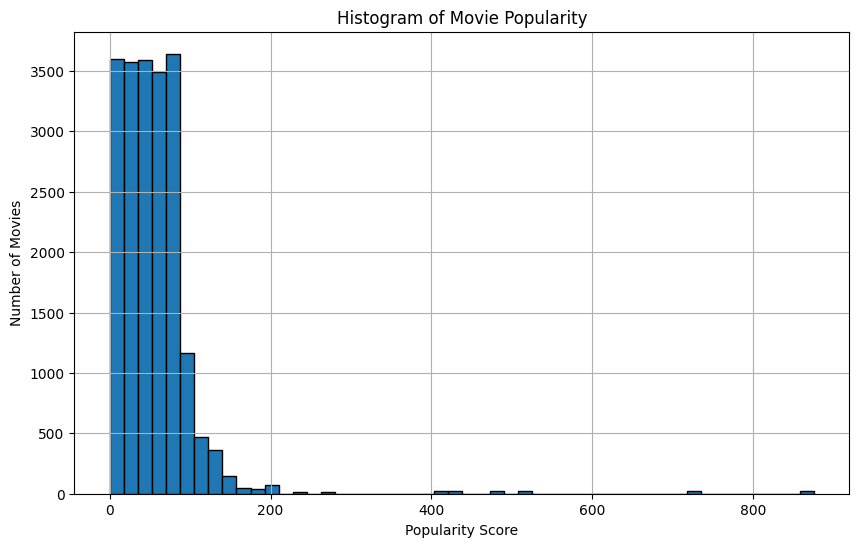

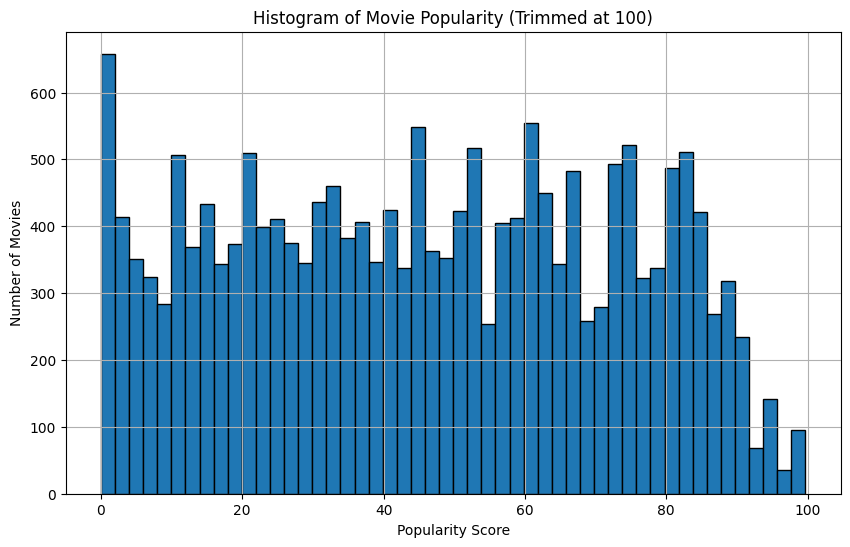

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_resampled['popularity'], bins=50, edgecolor='black')
plt.title('Histogram of Movie Popularity')
plt.xlabel('Popularity Score')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.savefig('histogram_popularity_simply_resampling_full.png')
plt.show()


plt.figure(figsize=(10, 6))
df_resampled[df_resampled['popularity'] < 100]['popularity'].hist(bins=50, edgecolor='black')
plt.title('Histogram of Movie Popularity (Trimmed at 100)')
plt.xlabel('Popularity Score')
plt.ylabel('Number of Movies')
plt.savefig('histogram_popularity_simply_resampling_trimmed.png')
plt.grid(True)
plt.show()

In [6]:
X = df_resampled.drop(columns=['popularity']).copy()
y = df_resampled['popularity']

print(X.dtypes)

budget                int64
runtime             float64
vote_average        float64
vote_count            int64
revenue               int64
release_year          int64
genres_score        float64
popularity_class      int64
dtype: object


In [7]:
# data for discretization of results

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, y.max()]
labels = list(range(10))

# SVR

In [8]:
from sklearn.svm import SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

kf = KFold(n_splits=10, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []



for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # MAE
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    
    # R2
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    y_pred_disc = pd.cut(y_pred, bins=bins, labels=labels, include_lowest=True)
    y_test_disc = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)
    
    mask = (~pd.isna(y_pred_disc)) & (~pd.isna(y_test_disc))
    y_pred_disc = y_pred_disc[mask]
    y_test_disc = y_test_disc[mask]

    acc = accuracy_score(y_test_disc, y_pred_disc)
    prec = precision_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    rec = recall_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    f1 = f1_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

print("\nMean Absolute Error (per fold):", mae_scores)
print("Mean MAE:", np.mean(mae_scores))

print("\nRoot Mean Squared Error (per fold):", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))

print("\nR2 - Coefficient of Determination (per fold):", r2_scores)
print("Mean R2:", np.mean(r2_scores))


Mean Absolute Error (per fold): [5.85834046882719, 6.462853812131253, 7.631452963607499, 7.943181664691587, 6.0878758143303555, 6.327997830003353, 7.504060127761429, 6.299455577045213, 8.69552084510726, 6.264011415131402]
Mean MAE: 6.9074750518636545

Root Mean Squared Error (per fold): [np.float64(38.30315836659081), np.float64(34.18525578892196), np.float64(41.27581247995157), np.float64(45.84840984723828), np.float64(35.047907099402224), np.float64(32.073697973240776), np.float64(44.211925625918404), np.float64(37.28575722299445), np.float64(48.88236178205237), np.float64(33.94745063758843)]
Mean RMSE: 39.10617368238993

R2 - Coefficient of Determination (per fold): [0.47238593767681547, 0.5460599759350351, 0.47690093846615156, 0.42433057752886105, 0.527958971974795, 0.5664347830345351, 0.4385422375627879, 0.49156979246384025, 0.41341386032596716, 0.5458869571997524]
Mean R2: 0.49034840321685413


In [9]:
# saving resoults to df
df_results = pd.DataFrame({
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R2': r2_scores
})
df_results.to_csv("3b_regression_simple_resample_SVR.csv", index=False)

In [10]:
# saving results to df (for comparison with classification)
df_results = pd.DataFrame({
    'acc': acc_scores,
    'prec': prec_scores,
    'rec': rec_scores,
    'f1': f1_scores
})
df_results.to_csv("3b_classification_simple_resample_SVR.csv", index=False)

# KNN

In [11]:
from sklearn.neighbors import KNeighborsRegressor

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

kf = KFold(n_splits=10, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    y_pred_disc = pd.cut(y_pred, bins=bins, labels=labels, include_lowest=True)
    y_test_disc = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)
    
    mask = (~pd.isna(y_pred_disc)) & (~pd.isna(y_test_disc))
    y_pred_disc = y_pred_disc[mask]
    y_test_disc = y_test_disc[mask]

    acc = accuracy_score(y_test_disc, y_pred_disc)
    prec = precision_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    rec = recall_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    f1 = f1_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)


print("\nMean Absolute Error (per fold):", mae_scores)
print("Mean MAE:", np.mean(mae_scores))

print("\nRoot Mean Squared Error (per fold):", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))

print("\nR2 - Coefficient of Determination (per fold):", r2_scores)
print("Mean R2:", np.mean(r2_scores))


Mean Absolute Error (per fold): [0.7968200961689592, 0.8355854510805508, 0.7940944149312383, 0.874543286738704, 0.8090399042239691, 0.7836420627701381, 0.8709354428290773, 0.8299084227897846, 0.8175410173870342, 0.8399917428290772]
Mean MAE: 0.8252101841748534

Root Mean Squared Error (per fold): [np.float64(1.8790094802627983), np.float64(2.2133203829954855), np.float64(1.9499915441852356), np.float64(2.1343363503645127), np.float64(1.827176928917169), np.float64(1.8171912619967474), np.float64(2.029924351790866), np.float64(2.0063786576289617), np.float64(2.0052992857789405), np.float64(1.917350300468185)]
Mean RMSE: 1.9779978544388903

R2 - Coefficient of Determination (per fold): [0.998730288267877, 0.9980971288758257, 0.9988324966493443, 0.9987524719235584, 0.9987170291903059, 0.9986082614965406, 0.998816419132652, 0.998527785097432, 0.9990128439005939, 0.9985513863391938]
Mean R2: 0.9986646110873325


In [12]:
# saving resoults to df
df_results = pd.DataFrame({
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R2': r2_scores
})
df_results.to_csv("3b_regression_simple_resample_KNN.csv", index=False)

In [13]:
# saving results to df (for comparison with classification)
df_results = pd.DataFrame({
    'acc': acc_scores,
    'prec': prec_scores,
    'rec': rec_scores,
    'f1': f1_scores
})
df_results.to_csv("3b_classification_simple_resample_KNN.csv", index=False)

# DECISION TREE

In [14]:
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline([
    ('tree', DecisionTreeRegressor(random_state=42))
])

kf = KFold(n_splits=10, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    y_pred_disc = pd.cut(y_pred, bins=bins, labels=labels, include_lowest=True)
    y_test_disc = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)
    
    mask = (~pd.isna(y_pred_disc)) & (~pd.isna(y_test_disc))
    y_pred_disc = y_pred_disc[mask]
    y_test_disc = y_test_disc[mask]

    acc = accuracy_score(y_test_disc, y_pred_disc)
    prec = precision_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    rec = recall_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    f1 = f1_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

print("\nMean Absolute Error (per fold):", mae_scores)
print("Mean MAE:", np.mean(mae_scores))

print("\nRoot Mean Squared Error (per fold):", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))

print("\nR2 - Coefficient of Determination (per fold):", r2_scores)
print("Mean R2:", np.mean(r2_scores))


Mean Absolute Error (per fold): [0.22799018713164315, 0.23338395137525902, 0.21636507907663413, 0.22824545432221474, 0.21073823919451207, 0.22720003831042548, 0.23643330304520005, 0.20558536665030736, 0.1977124901768308, 0.22234961345777332]
Mean MAE: 0.22060037227408

Root Mean Squared Error (per fold): [np.float64(0.8353621774595691), np.float64(0.8800683161992161), np.float64(0.8293150043352207), np.float64(0.8934011871838828), np.float64(0.8171201959544736), np.float64(0.8847860557440477), np.float64(0.8817755485403354), np.float64(0.7976602603087719), np.float64(0.7821091268678716), np.float64(0.8702355766343538)]
Mean RMSE: 0.8471833449227744

R2 - Coefficient of Determination (per fold): [0.999749044449428, 0.9996991475304825, 0.9997888302405532, 0.9997814163584359, 0.9997434172480296, 0.9996700615712496, 0.9997766662632209, 0.999767308069636, 0.9998498372742842, 0.9997015831700216]
Mean R2: 0.9997527312175343


In [15]:
# saving results to df (for comparison with classification)
df_results = pd.DataFrame({
    'acc': acc_scores,
    'prec': prec_scores,
    'rec': rec_scores,
    'f1': f1_scores
})
df_results.to_csv("3b_classification_simple_resample_DT.csv", index=False)

In [16]:
# saving resoults to df
df_results = pd.DataFrame({
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R2': r2_scores
})
df_results.to_csv("3b_regression_simple_resample_DT.csv", index=False)

# MULTILAYER PERCEPTRON (MLP)

In [17]:
from sklearn.neural_network import MLPRegressor

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, early_stopping=True, random_state=42))
])

kf = KFold(n_splits=10, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    y_pred_disc = pd.cut(y_pred, bins=bins, labels=labels, include_lowest=True)
    y_test_disc = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)
    
    mask = (~pd.isna(y_pred_disc)) & (~pd.isna(y_test_disc))
    y_pred_disc = y_pred_disc[mask]
    y_test_disc = y_test_disc[mask]

    acc = accuracy_score(y_test_disc, y_pred_disc)
    prec = precision_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    rec = recall_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    f1 = f1_score(y_test_disc, y_pred_disc, average='macro', zero_division=0)
    
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

print("\nMean Absolute Error (per fold):", mae_scores)
print("Mean MAE:", np.mean(mae_scores))

print("\nRoot Mean Squared Error (per fold):", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))

print("\nR2 - Coefficient of Determination (per fold):", r2_scores)
print("Mean R2:", np.mean(r2_scores))



Mean Absolute Error (per fold): [1.9680100015628939, 1.9452237646874617, 2.1341255560050465, 2.00383002894712, 1.96198738201682, 2.1166039073990506, 2.0549630281647535, 2.2482280618363553, 1.9808750123978847, 2.4122778209841536]
Mean MAE: 2.082612456400154

Root Mean Squared Error (per fold): [np.float64(2.6624494841733273), np.float64(2.911582392622122), np.float64(3.25032117803745), np.float64(2.753998130435804), np.float64(2.777927727233049), np.float64(3.0784742116652004), np.float64(2.973449343911638), np.float64(3.189760166548774), np.float64(3.382127840076246), np.float64(3.4512599577961236)]
Mean RMSE: 3.0431350432499733

R2 - Coefficient of Determination (per fold): [0.9974507645872175, 0.9967070966990804, 0.9967562659883907, 0.9979229263863063, 0.9970345032342606, 0.9960058221168122, 0.9974604350914759, 0.9962789845670733, 0.9971919329488023, 0.9953064117273513]
Mean R2: 0.9968115143346772


In [18]:
# saving results to df (for comparison with classification)
df_results = pd.DataFrame({
    'acc': acc_scores,
    'prec': prec_scores,
    'rec': rec_scores,
    'f1': f1_scores
})
df_results.to_csv("3b_classification_simple_resample_MLP.csv", index=False)

In [19]:
# saving resoults to df
df_results = pd.DataFrame({
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R2': r2_scores
})
df_results.to_csv("3b_regression_simple_resample_MLP.csv", index=False)